In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import datetime
import os
import sys
import time
import yaml

from pprint import pprint

In [ ]:
sys.path.append("/home/caleml/main-pe/")

In [ ]:
import numpy as np

from data.datasets.h36m import Human36M
from data.loader import BatchLoader
from data.utils import transform, camera
from data.utils.data_utils import TEST_MODE, TRAIN_MODE, VALID_MODE

from model import config, measures
from model.networks.multi_branch_model import MultiBranchModel
from model.utils import pose_format, log

## dataset

In [ ]:
# local loading
local_h36m_path = '/home/caleml/datasets/h36m'
local_h36m = Human36M(local_h36m_path, dataconf=config.human36m_dataconf, poselayout=pose_format.pa17j3d, topology='frames') 

In [ ]:
h36m_val = BatchLoader(local_h36m, 
                       ['frame'],
                       ['pose_w', 'pose_uvd', 'afmat', 'camera'], 
                       VALID_MODE,
                       batch_size=local_h36m.get_length(VALID_MODE), 
                       shuffle=True)

log.printcn(log.OKBLUE, 'Preloading Human3.6M validation samples...')

[x_val], [pw_val, puvd_val, afmat_val, scam_val] = h36m_val[0]

In [ ]:
dataset = {
    'x_val': x_val,
    'pw_val': pw_val,
    'puvd_val': puvd_val,
    'afmat_val': afmat_val,
    'scam_val': scam_val
}

## eval func

In [ ]:
def eval_human36m_sc_error(model,
                           x,
                           pose_w,
                           afmat,
                           rootz,
                           scam,
                           resol_z=2000.,
                           batch_size=8,
                           map_to_pa17j=None,
                           logdir=None,
                           verbose=True):

    assert len(x) == len(pose_w) == len(afmat) == len(scam)

    num_blocks = len(model.outputs)

    y_true_w = pose_w.copy()
    if map_to_pa17j is not None:
        y_true_w = y_true_w[:, map_to_pa17j, :]
    y_pred_w = np.zeros((num_blocks,) + y_true_w.shape)
    if rootz.ndim == 1:
        rootz = np.expand_dims(rootz, axis=-1)

    pred = model.predict(x, batch_size=batch_size, verbose=1)

    # Move the root joints from GT poses to origin
    y_true_w -= y_true_w[:, 0:1, :]

    if verbose:
        log.printc(log.WARNING, 'Avg. mm. error:')

    lower_err = np.inf
    scores = []

    for b in range(num_blocks):

        if num_blocks > 1:
            y_pred = pred[b]
        else:
            y_pred = pred

        # ??
        y_pred = y_pred[:, :, 0:3]

        # project normalized coordiates to the image plane
        y_pred[:, :, 0:2] = transform.transform_pose_sequence(afmat.copy(), y_pred[:, :, 0:2], inverse=True)

        # Recover the absolute Z
        y_pred[:, :, 2] = (resol_z * (y_pred[:, :, 2] - 0.5)) + rootz
        y_pred_uvd = y_pred[:, :, 0:3]

        # camera inverse projection
        for j in range(len(y_pred_uvd)):
            cam = camera.camera_deserialize(scam[j])
            y_pred_w[b, j, :, :] = cam.inverse_project(y_pred_uvd[j])

        # Move the root joint from predicted poses to the origin
        y_pred_w[b, :, :, :] -= y_pred_w[b, :, 0:1, :]

        err_w = measures.mean_distance_error(y_true_w[:, 0:, :], y_pred_w[b, :, 0:, :])
        scores.append(err_w)
        if verbose:
            log.printc(log.WARNING, ' %.1f' % err_w)

        # Keep the best prediction
        if err_w < lower_err:
            lower_err = err_w

    if verbose:
        log.printcn('', '')

    if logdir is not None:
        np.save('%s/y_pred_w.npy' % logdir, y_pred_w)
        np.save('%s/y_true_w.npy' % logdir, y_true_w)

    log.printcn(log.WARNING, 'Final averaged error (mm): %.3f' % lower_err)

    return scores

# model folder

In [ ]:
# single h5 eval
weights_path = '/home/caleml/pe_experiments/test_from_gpuserver2/weights_036.h5'
eval_model = MultiBranchModel(dim=3, n_joints=17, nb_pose_blocks=1)
eval_model.load_weights(weights_path, pose_only=True)
scores = eval_human36m_sc_error(eval_model.model, 
                                x_val, 
                                pw_val, 
                                afmat_val,
                                puvd_val[:,0,2], 
                                scam_val,  
                                batch_size=24)

pprint(scores)

In [ ]:
# whole folder eval
def eval_folder(exp_folder, dataset, pose_only=False):
    config_path = os.path.join(exp_folder, 'config.yaml')
    
    # config
    with open(config_path, 'r') as f_conf:
        config = yaml.load(f_conf)
        
    # model
    eval_model = MultiBranchModel(dim=3, n_joints=17, nb_pose_blocks=int(config['pose_blocks']), verbose=False)
        
    # find weights paths
    weights = list()
    for filename in os.listdir(exp_folder):
        if filename.endswith(".h5") and filename.startswith("weights_"):
            weights.append(os.path.join(exp_folder, filename))
            
    weights.sort()
    print("Found %s weights paths" % len(weights))
    
    # actual eval
    all_scores = list()
    for i, weights_path in enumerate(weights[39:]):
        time1 = time.time()
        print("Eval of weights_path %s" % weights_path)
        eval_model.load_weights(weights_path, pose_only=pose_only)
        
        scores = eval_human36m_sc_error(eval_model.model, 
                                        dataset['x_val'], 
                                        dataset['pw_val'], 
                                        dataset['afmat_val'],
                                        dataset['puvd_val'][:,0,2], 
                                        dataset['scam_val'],  
                                        batch_size=24)
        
        time2 = time.time()
        print("Scores for epoch %s: %s (in %s s)" % (i + 40, str(scores), time2 - time1))
        all_scores.append(max(scores))
        
    return all_scores
        

In [ ]:
exp_baseline_path = '/home/caleml/pe_experiments/exp_baseline_1b_bs32_h36m_201903221052/'
all_scores_baseline = eval_folder(exp_baseline_path, dataset, pose_only=True)

In [ ]:
print(all_scores_baseline)
history_baseline = [91.752, 82.462, 79.423, 88.836, 84.020, 86.886, 86.680, 79.484, 78.599, 84.097, 76.193, 77.141, 78.207, 81.432, 78.589, 77.009, 77.462, 76.312, 78.666]
all_scores_baseline = history_baseline + all_scores_baseline[1:]
assert len(all_scores_baseline) == 60

In [ ]:
exp_hybrid_path = '/home/caleml/pe_experiments/exp_20190322_1942_hybrid_h36m__1b_bs16/'
all_scores_hybrid = eval_folder(exp_hybrid_path, dataset, pose_only=False)

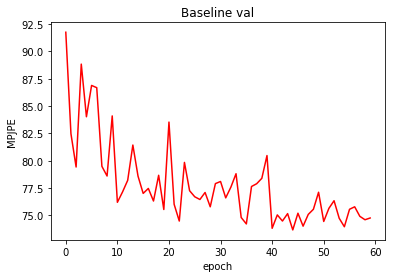

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

x = list(range(60))

plt.plot(x, all_scores_baseline, 'r')
# plt.plot(x, all_scores_hybrid, 'b')
plt.title('Baseline val')
plt.xlabel('epoch')
plt.ylabel('MPJPE')
plt.show()

plt.savefig('/home/caleml/pe_experiments/exp_baseline_1b_bs32_h36m_201903221052/eval.png')

In [1]:
all_scores_baseline = [91.75194501441577, 82.46205898898975, 79.4226132617545, 88.8355976647399, 84.02042960060331, 86.88580619918093, 86.67989807960359, 79.48412115594127, 78.59867146077222, 84.09675808749151, 76.1932848291697, 77.14141621003114, 78.2065916383256, 81.43181095386677, 78.58923745192591, 77.008543664543, 77.46245838987596, 76.31208539465088, 78.66618899639796, 75.53613154051648, 83.53373459959678, 76.01499659875537, 74.4797050967049, 79.84342586353483, 77.25320791938644, 76.69853350783292, 76.45083687520106, 77.09345226614492, 75.78290824659078, 77.9041891354044, 78.09753993393933, 76.60042799938726, 77.5805151579404, 78.8091096371011, 74.80468494705836, 74.2166559806093, 77.63991530864764, 77.89325147099139, 78.38807773666701, 80.47055450518361, 73.81642579401903 , 75.0416006683364 , 74.48196930787806 , 75.15854590724823 , 73.66802279838019 , 75.19603076463348 , 74.01143213366338 , 75.08591589680957 , 75.55668131643323 , 77.11394826271881 , 74.44167918712098 , 75.63973677387979 , 76.3378921014415 , 74.73289168541717 , 73.95828566807859 , 75.55537095370421 , 75.78301989366678 , 74.91063809506264 , 74.59803512567959 , 74.75948044066446]